In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textract
import os

import string
import re
import random

from tqdm.notebook import tqdm

from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings('ignore')

Start notebook by reading in .pkl file below

In [ ]:
# for writing preprocessing .ipynb to .py file
# !jupyter nbconvert --to script preprocess_docx.ipynb

In [ ]:
# # 1. Get filenames (n=110 in 2020-2021)

# os.getcwd()
# files = sorted([f for f in os.listdir('.') if os.path.isfile(f)])
# files = [f for f in files if f[-5:] == '.docx']
# len(files)

In [ ]:
# # 2. Get titles

# title_list = []

# for file in tqdm(files):
#     text = textract.process('/Users/markstreer/Documents/mytranslations/' + file, 
#                         extension="docx").decode('UTF-8')
#     text = text.split("\n")
#     text = [string for string in text if string] # remove empty strings
#     text = [sent for sent in text if (len(word_tokenize(sent)) > 3)]
#     title = text[0]
#     title_list.append(title)

# for i, title in enumerate(title_list):
#     if title[:6] == 'Title':
#         title_list[i] = title[7:]

## 1. Preprocessing
#### Part I
Punctuation, numbers, lowercase

In [ ]:
# # Preprocess text (remove punctuation, numbers etc.)

# from preprocess_docx import preprocess_docx  #.py file in same directory

# filename_list = []
# master_list = []

# for file in tqdm(files):
#     filename_list.append(file[:16]) #unique identifier
#     text = textract.process('/Users/markstreer/Documents/mytranslations/' + file, 
#                         extension="docx").decode('UTF-8')
#     doc = preprocess_docx(text)
#     master_list.append(doc)

# df = pd.DataFrame(zip(filename_list, title_list, master_list), columns=['doc_ID', 'doc_title', 'doc_text'])
# df.to_pickle('dfmaster_20211111.pkl')

In [2]:
# 2021-11-11: Start notebook from here

df_new = pd.read_pickle('dfmaster_20211111.pkl')

master_list = list(df_new.doc_text)
title_list = list(df_new.doc_title)


for title in title_list:
    print(title)
    #print('\n')

α1-microglobulin reduction rate is a useful marker of online hemodiafiltration efficiency
Clinical significance of skeletal muscle mass in cervical cancer treated by concurrent chemoradiation therapy
Development of a scaffold-free 3D bio fabrication system capable of creating three-dimensional structures consisting of cells alone
Relationships of quantitative and qualitative indices of lower-extremity skeletal muscle in community-dwelling older adults with an objective measure of masticatory function
Associations between arthroplasty history and cyclic citrullinated peptide antibody titers in rheumatoid arthritis patients
Prospective study of safety and effectiveness of early rehabilitation program for patients with subarachnoid hemorrhage
Physical fitness levels among colon cancer survivors with stoma: a preliminary study
Public Awareness of Medical Research Terminology and Physicians’ Predictions Thereof
Investigation of Inspiratory intercostal muscle activity in three patients with 

In [ ]:
# # for inspecting titles

# for i in range(len(files)):
#     print(f'File: {filename_list[i]}')
#     print(f'Title: {title_list[i]}')
#     print('\n')

#### Part II
Remove stopwords, lemmatize

In [3]:
# Topic specialization improved after removing the 1000 most-frequent words in English

top_thousand_words_df = pd.read_csv('1-1000.txt', header=None)
top_1000_words_eng = top_thousand_words_df[0].tolist()
top_1000_words_eng = [word.lower() for word in top_1000_words_eng]

In [4]:
# 1. Remove stop words
from nltk.corpus import stopwords
from nltk import word_tokenize

stopwords = stopwords.words('english')

# Specify personal stopwords
stopwords = stopwords + ['abbr-etal', 'abbr-ie', 'abbr-eg',
                        'fig', 'figs', 'table', 'tables'] \
                       + top_1000_words_eng  # important for terminological specificity       

# Remove them
master_list_new = []
for doc in tqdm(master_list):
    doc_new = ''
    for word in word_tokenize(doc):
        if word not in stopwords:
            doc_new += (word + ' ')
    master_list_new.append(doc_new.strip())
    
# master_list_new

  0%|          | 0/110 [00:00<?, ?it/s]

In [5]:
# 2. Lemmatize documents

from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

master_list = []
wnl = WordNetLemmatizer()

for doc in tqdm(master_list_new):
    doc_new = ''
    for word, tag in pos_tag(word_tokenize(doc)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
        else:
            lemma = wnl.lemmatize(word, wntag)
        doc_new += (lemma + ' ')
    master_list.append(doc_new.strip())

  0%|          | 0/110 [00:00<?, ?it/s]

In [6]:
# 3. Remove words < 4 char & stopwords (to catch new lemmas)

master_list_new = []

for doc in master_list:
    doc_new = ''
    for word in word_tokenize(doc):
        if len(word) > 3 & (word not in stopwords):     #remove 1, 2, 3-char 'words' & stop words
            doc_new += (word + ' ')
    master_list_new.append(doc_new.strip())

master_list = [re.sub('/  +/g', ' ', sent) for sent in master_list_new] #condense whitespace to 1-space
master_list = [string for string in master_list if string]              #remove empty strings

for i, x in enumerate(master_list[:10]):
    print(master_list[i][:80])

microglobulin reduction useful marker online hemodiafiltration efficiency online
clinical significance skeletal muscle cervical cancer treat concurrent chemoradi
development scaffold-free fabrication capable create three-dimensional structure
relationship quantitative qualitative index lower-extremity skeletal muscle comm
association arthroplasty cyclic citrullinated peptide antibody titer rheumatoid 
prospective safety effectiveness rehabilitation program patient subarachnoid hem
physical fitness level colon cancer survivor stoma preliminary abstract backgrou
public awareness medical research terminology physician prediction thereof condi
investigation inspiratory intercostal muscle activity patient spinal injury pilo
bilateral pulmonary embolism occur self-isolation covid pandemic novel coronavir


## 2. Modeling
### 2.1. Vectorize

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

# Baseline model
tf_vectorizer = CountVectorizer(stop_words='english',
                                #max_features=1000,
                                #min_df=2,
                                #max_df=0.5
                               )
doc_word_tf = tf_vectorizer.fit_transform(master_list)

# Superior model for docs high in technical terminology
tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   max_features=1000,
                                   min_df=2,
                                   max_df=0.5
                                  )
doc_word_tfidf = tfidf_vectorizer.fit_transform(master_list)

# doc_word_tf.shape
# doc_word_tfidf.shape

In [8]:
# Function for display top N words in a given topic
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix+1)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### 2.2 SVD
Didn't work as well as NMF, shelved 2021-11-09

In [ ]:
# num_topics = 16

# lsa_tf = TruncatedSVD(num_topics)
# doc_topic_tf = lsa_tf.fit_transform(doc_word_tf)
# #lsa_tf.explained_variance_ratio_

# lsa_tfidf = TruncatedSVD(num_topics)
# doc_topic_tfidf = lsa_tfidf.fit_transform(doc_word_tfidf)
# #lsa_tfidf.explained_variance_ratio_

# topic_word_tf = pd.DataFrame(lsa_tf.components_.round(3),
#              index = [f'component_{n+1}' for n in range(num_topics)],
#              columns = tf_vectorizer.get_feature_names())

# topic_word_tfidf = pd.DataFrame(lsa_tfidf.components_.round(3),
#              index = [f'component_{n+1}' for n in range(num_topics)],
#              columns = tfidf_vectorizer.get_feature_names())

In [ ]:
#display_topics(lsa_tf, tf_vectorizer.get_feature_names(), 10)

In [ ]:
#display_topics(lsa_tfidf, tfidf_vectorizer.get_feature_names(), 10)

### 2.3 NMF

In [9]:
num_topics = 16

# nmf_tf = NMF(n_components=num_topics)
# doc_topic_tf = nmf_tf.fit_transform(doc_word_tf)
# topic_word_tf = pd.DataFrame(nmf_tf.components_.round(3),
#              index = [f'component_{n+1}' for n in range(num_topics)],
#              columns = tf_vectorizer.get_feature_names())

# Golden Boy, The Chosen One
nmf_tfidf = NMF(n_components=num_topics)
doc_topic_tfidf = nmf_tfidf.fit_transform(doc_word_tfidf)
topic_word_tfidf = pd.DataFrame(nmf_tfidf.components_.round(3),
             index = [f'component_{n+1}' for n in range(num_topics)],
             columns = tfidf_vectorizer.get_feature_names())

In [10]:
#display_topics(nmf_tf, tf_vectorizer.get_feature_names(), 10)

In [11]:
display_topics(nmf_tfidf, tfidf_vectorizer.get_feature_names(), 20)


Topic  1
older, dementia, health, community, cognitive, adult, literacy, dwelling, elderly, frailty, fall, function, self, lifestyle, population, mental, capacity, relationship, group, rural

Topic  2
surgery, case, cancer, procedure, operation, laparoscopic, surgical, gastric, complication, postoperative, underwent, treat, colon, node, lymph, outcome, balloon, uterine, secondary, review

Topic  3
covid, infection, pandemic, emergency, pulmonary, chest, suspect, nurse, sars, cov, isolation, service, antibiotic, bacteremia, society, culture, shortage, negative, admission, continue

Topic  4
cell, culture, cartilage, tissue, expression, organ, protein, induce, differentiation, apoptosis, stain, experiment, production, differentiate, plate, needle, enhance, medium, gland, technique

Topic  5
muscle, sarcopenia, skeletal, thickness, baseline, stress, frailty, subjective, lower, ultrasound, significantly, subject, index, week, chest, maximum, indicator, cancer, injection, cervical

Topic  

### 2.4 LDA
Didn't work so well, shelved 2021-11-09

In [ ]:
# from sklearn.decomposition import LatentDirichletAllocation

# # for TF DTM
# lda_tf = LatentDirichletAllocation(n_components=16, random_state=0)
# lda_tf.fit(doc_word_tf)

# # for TFIDF DTM
# lda_tfidf = LatentDirichletAllocation(n_components=16, random_state=0)
# lda_tfidf.fit(doc_word_tfidf)

In [ ]:
# import pyLDAvis
# import pyLDAvis.sklearn
# pyLDAvis.enable_notebook()

# pyLDAvis.sklearn.prepare(lda_tf, doc_word_tf, tf_vectorizer)

### 2.5 K-means
First: Decide on optimal num_clusters.

In [12]:
# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
plt.rcParams['figure.figsize'] = [6,6]

Text(0, 0.5, 'inertia_score')

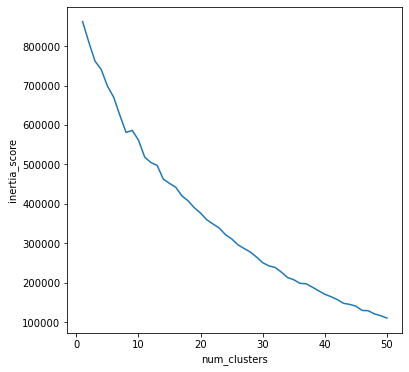

In [13]:
# K-means gridsearch

x = [n for n in range(1, 51)]
y = []

for num in x:
    km = KMeans(n_clusters=num)
    km.fit(doc_word_tf.toarray())   # 'elbow' easier to distinguish in _tf
    Y = km.inertia_
    y.append(Y)

plt.plot(x,y)
plt.xlabel('num_clusters')
plt.ylabel('inertia_score')
#plt.set_title('K-Means Cluster Count Validation')  #optimal n_clusters 15~20?
# Should k be smaller (given only 110 docs?)

Second: Cluster docs to compare labels

In [14]:
# 1. Collect labels predicted by K-means in dictionary
from collections import defaultdict

clusters = defaultdict(int)
km = KMeans(n_clusters=16)        #set k here!!!
km.fit(doc_word_tfidf.toarray())

for label in km.labels_:
    clusters[label] += 1
    
cluster_counts = dict(sorted(clusters.items(), key=lambda item: item[1], reverse=True))
cluster_counts

{0: 13,
 4: 12,
 3: 11,
 1: 11,
 12: 11,
 7: 8,
 10: 7,
 8: 7,
 15: 6,
 2: 5,
 9: 5,
 13: 4,
 11: 3,
 6: 3,
 14: 2,
 5: 2}

In [15]:
# 2. Inspect titles of docs clustered together

df = pd.DataFrame(zip(title_list,
                   km.labels_),
                   columns=['title', 'label_km'])

df_masked = df[df.label_km == 7]  # insert topic num here (0-15)
for title in df_masked.title:
    print(title) # insert doc num here (idx)

A case of bilateral pulmonary embolism occurring under self-isolation during the COVID-19 pandemic
Nursing homes and the COVID-19 challenge in Japan
Delayed treatment of bacteremia during the COVID-19 pandemic
Protection Stroke Code for COVID-19 based on Task Calc. Stroke: Ensuring the continued provision of stroke care during the pandemic
Extracorporeal CPR should not be performed on confirmed or suspected COVID-19 patients
A case of invasive pneumococcal infection with suspected involvement of immune dysfunction due to splenic hypoplasia
Frailty countermeasures during the coronavirus pandemic
Protection from tuberculosis for infants in the COVID-19 era.


## 3. Document similarity & interpretation

In [16]:
# Name topics for interpretability of column headings below
# Note that topic numbers DO NOT MAP to cluster numbers: C_02 != 02.Surgery

clusternames = [f'C_{n}' for n in range(0,16)]

tnames_human_16 = ['01.CommunityHealth', '02.Surgery', '03.COVID', '04.StemCell',
                   '05.Physiology', '06.Cancer', '07.Neuroscience', '08.SocWelfare',
                   '09.Rehabilitation', '10.ObGyn', '11.NursingEd', '12.Endovascular',
                   '13.Stroke', '14.ClinTrial', '15.PubPolicy', '16.Genomics']

tnames_human_08 = ['01.Nursing', '02.Surgery', '03.COVID', '04.MolBioTherap',
                   '05.FuncHealth', '06.Cancer', '07.Neuroscience', '08.Rehabilitation']

In [17]:
# Prepare dataframe
df_doc_topic_tfidf = pd.DataFrame(doc_topic_tfidf, 
                       #index=title_list,
                       columns=tnames_human_16  # or _8
                      )

df = pd.DataFrame(zip(title_list,
                   km.labels_),
                   columns=['title', 'km_label'])
df = pd.concat([df, df_doc_topic_tfidf], axis=1)

### 3.1 Find similar docs

In [18]:
# show a specific (or random) doc in the corpus along with the 3 docs most similar to it
def show_most_similar_doc(i, rand=False): 
    from sklearn.metrics import pairwise_distances
    if rand==True:
        i = random.randint(0, len(title_list)-1)
    j1 = pairwise_distances(doc_topic_tfidf[i].reshape(1, -1),
                           doc_topic_tfidf, metric='cosine').argsort()[0][1]  #0th term is same doc!
    j2 = pairwise_distances(doc_topic_tfidf[i].reshape(1, -1),
                           doc_topic_tfidf, metric='cosine').argsort()[0][2]
    j3 = pairwise_distances(doc_topic_tfidf[i].reshape(1, -1),
                           doc_topic_tfidf, metric='cosine').argsort()[0][3]
    
    print(f"Doc {i}: Cluster {km.labels_[i]}")
    print(title_list[i])
    print('\n')
    print('Top 3 Similar Docs:')
    print(f"Doc {j1}: Cluster {km.labels_[j1]}")
    print(title_list[j1])
    print(f"Doc {j2}: Cluster {km.labels_[j2]}")
    print(title_list[j2])
    print(f"Doc {j3}: Cluster {km.labels_[j3]}")
    print(title_list[j3])
    
    df_show = df.iloc[[i, j1, j2, j3]]
    
    return df_show

show_most_similar_doc(46, rand=True)

Doc 82: Cluster 10
Development and validation of an assessment tool for rehabilitation skills training for prospective and practicing physiotherapists


Top 3 Similar Docs:
Doc 84: Cluster 10
Cancer rehabilitation care as provided by designated cancer care hospitals in Japan
Doc 107: Cluster 10
Higher brain dysfunction in clinical rehabilitation
Doc 5: Cluster 10
Prospective study of safety and effectiveness of early rehabilitation program for patients with subarachnoid hemorrhage


,title,km_label,01.CommunityHealth,02.Surgery,03.COVID,04.StemCell,05.Physiology,06.Cancer,07.Neuroscience,08.SocWelfare,09.Rehabilitation,10.ObGyn,11.NursingEd,12.Endovascular,13.Stroke,14.ClinTrial,15.PubPolicy,16.Genomics
82,Development and validation of an assessment to...,10,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.488420,0.0,0.000000,0.198139,0.000000,0.0,0.000000,0.00000
84,Cancer rehabilitation care as provided by desi...,10,0.000000,0.046365,0.011107,0.0,0.011553,0.027832,0.000000,0.000000,0.612459,0.0,0.000000,0.000000,0.000000,0.0,0.009035,0.00000
107,Higher brain dysfunction in clinical rehabilit...,10,0.000427,0.000000,0.000000,0.0,0.000000,0.000000,0.055151,0.000000,0.584538,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.00000
5,Prospective study of safety and effectiveness ...,10,0.000000,0.097129,0.000000,0.0,0.000000,0.000000,0.000000,0.166675,0.389616,0.0,0.161763,0.000000,0.130028,0.0,0.000000,0.00812


In [ ]:
# show titles of all docs in all clusters

for k in range(0,16): # or 0,7
    print(f'Cluster {k}:')
    for title in df[df.km_label==k].title[:-1]:
        print(title)
    print('\n')

### 3.2 Check interpretability of clusters

In [19]:
# Inspect mean doc-topic vector of docs in each cluster

for n in range(0, num_topics):
    dfx = df[(df.km_label==n)].iloc[:,2:]
    title = f'Cluster #{n} Mean'
    df.loc[f'C_{n}'] = [title, n] + [np.mean(dfx[col]) for col in tnames_human_16]  # or _08
    
df_bycluster = df.iloc[-16:, 2:]        # or -8
df_bycluster.columns = tnames_human_16  # or _08
df_bycluster.T

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,C_11,C_12,C_13,C_14,C_15
01.CommunityHealth,0.003775,0.019411,0.042977,0.084297,0.001654,0.001562,0.000000,0.021327,0.017676,0.000452,0.022895,0.001103,0.029857,0.033663,0.000842,0.007993
02.Surgery,0.226411,0.000832,0.013773,0.016010,0.004144,0.000000,0.033762,0.002100,0.003109,0.019102,0.043614,0.014263,0.005111,0.001383,0.046565,0.015754
03.COVID,0.046913,0.012787,0.002383,0.005142,0.003997,0.000000,0.000000,0.405281,0.002976,0.000382,0.001953,0.065974,0.000854,0.000000,0.000512,0.046847
04.StemCell,0.005136,0.001275,0.024649,0.004301,0.296654,0.000000,0.000000,0.015092,0.001215,0.040188,0.000482,0.000000,0.004927,0.000000,0.044578,0.004714
05.Physiology,0.007925,0.002513,0.092648,0.228164,0.011733,0.000000,0.000610,0.006959,0.003539,0.002607,0.018585,0.035891,0.011348,0.000905,0.008015,0.000962
06.Cancer,0.010763,0.000440,0.000678,0.005498,0.001179,0.000000,0.000000,0.012550,0.000171,0.446779,0.013303,0.000000,0.007385,0.001606,0.000000,0.000373
07.Neuroscience,0.005557,0.002282,0.031622,0.017647,0.023130,0.000000,0.019636,0.004820,0.002371,0.008102,0.009170,0.009469,0.268778,0.002430,0.012371,0.000000
08.SocWelfare,0.003878,0.016766,0.064230,0.016462,0.005087,0.000000,0.000000,0.000785,0.344876,0.001615,0.060309,0.000000,0.075690,0.000000,0.002690,0.010533
09.Rehabilitation,0.007981,0.001392,0.006526,0.003494,0.007547,0.010265,0.000000,0.004891,0.045348,0.000524,0.335832,0.029102,0.005998,0.008959,0.000000,0.003252
10.ObGyn,0.018291,0.001802,0.015807,0.001401,0.001768,0.014933,0.008746,0.003321,0.008418,0.028169,0.029618,0.000000,0.008174,0.000069,0.008074,0.352145


In [20]:
# for a given cluster, show the top three topics & most-representative docs
# (i.e., closest in cosine similarity to the cluster centroid)

def show_top_docs_and_topics_in_cluster(idx):
    arr = np.array(df_bycluster.loc[idx])
    top_topics = list(arr.argsort()[-3:][::-1])
    output = [(tnames_human_16[topic], arr[topic]) for topic in top_topics]
    
    print(f'Top Three Topics in Cluster {idx} (mean of docs)')
    for tpl in output:
        print(tpl)
    print('\n')
    
    from sklearn.metrics import pairwise_distances
    #i = random.randint(0, len(title_list)-1)
    j1 = pairwise_distances(np.array(df_bycluster.loc[idx]).reshape(1, -1),
                           doc_topic_tfidf, metric='cosine').argsort()[0][0]
    j2 = pairwise_distances(np.array(df_bycluster.loc[idx]).reshape(1, -1),
                           doc_topic_tfidf, metric='cosine').argsort()[0][1]
    j3 = pairwise_distances(np.array(df_bycluster.loc[idx]).reshape(1, -1),
                           doc_topic_tfidf, metric='cosine').argsort()[0][2]
    
    print('Top Three Docs in Cluster (i.e. nearest to centroid):')
    print(f"Doc {j1}: Cluster {km.labels_[j1]}")
    print(title_list[j1])
    print(f"Doc {j2}: Cluster {km.labels_[j2]}")
    print(title_list[j2])
    print(f"Doc {j3}: Cluster {km.labels_[j3]}")
    print(title_list[j3])

In [26]:
show_top_docs_and_topics_in_cluster('C_5') # insert 'C_0' ... 'C_15'

Top Three Topics in Cluster C_5 (mean of docs)
('13.Stroke', 0.7128277915678625)
('10.ObGyn', 0.014932654704601468)
('09.Rehabilitation', 0.01026482146508265)


Top Three Docs in Cluster (i.e. nearest to centroid):
Doc 92: Cluster 5
Development and feasibility of an intervention model for family surrogate decision-makers of acute stroke victims
Doc 14: Cluster 5
Everyday experiences of wives of elderly stroke victims after home discharge
Doc 72: Cluster 7
Protection Stroke Code for COVID-19 based on Task Calc. Stroke: Ensuring the continued provision of stroke care during the pandemic


### Appendix: Word Cloud Visualization

In [31]:
# Enter topic number (0-15)
topic_num = 7
topic = nmf_tfidf.components_[topic_num]
feature_names = tfidf_vectorizer.get_feature_names()
data = [feature_names[i] for i in topic.argsort()[:-21:-1]]  #top 20 terms

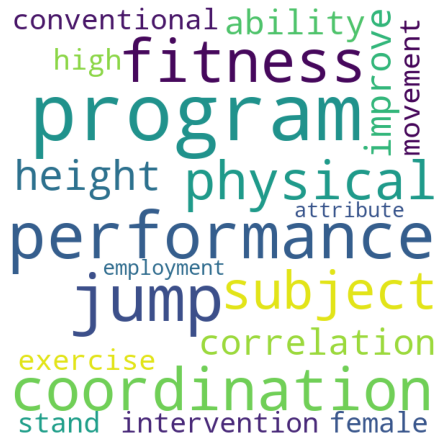

In [32]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in data:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 600, height = 600,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
#plt.savefig('wordcloud7.jpg')
plt.show()

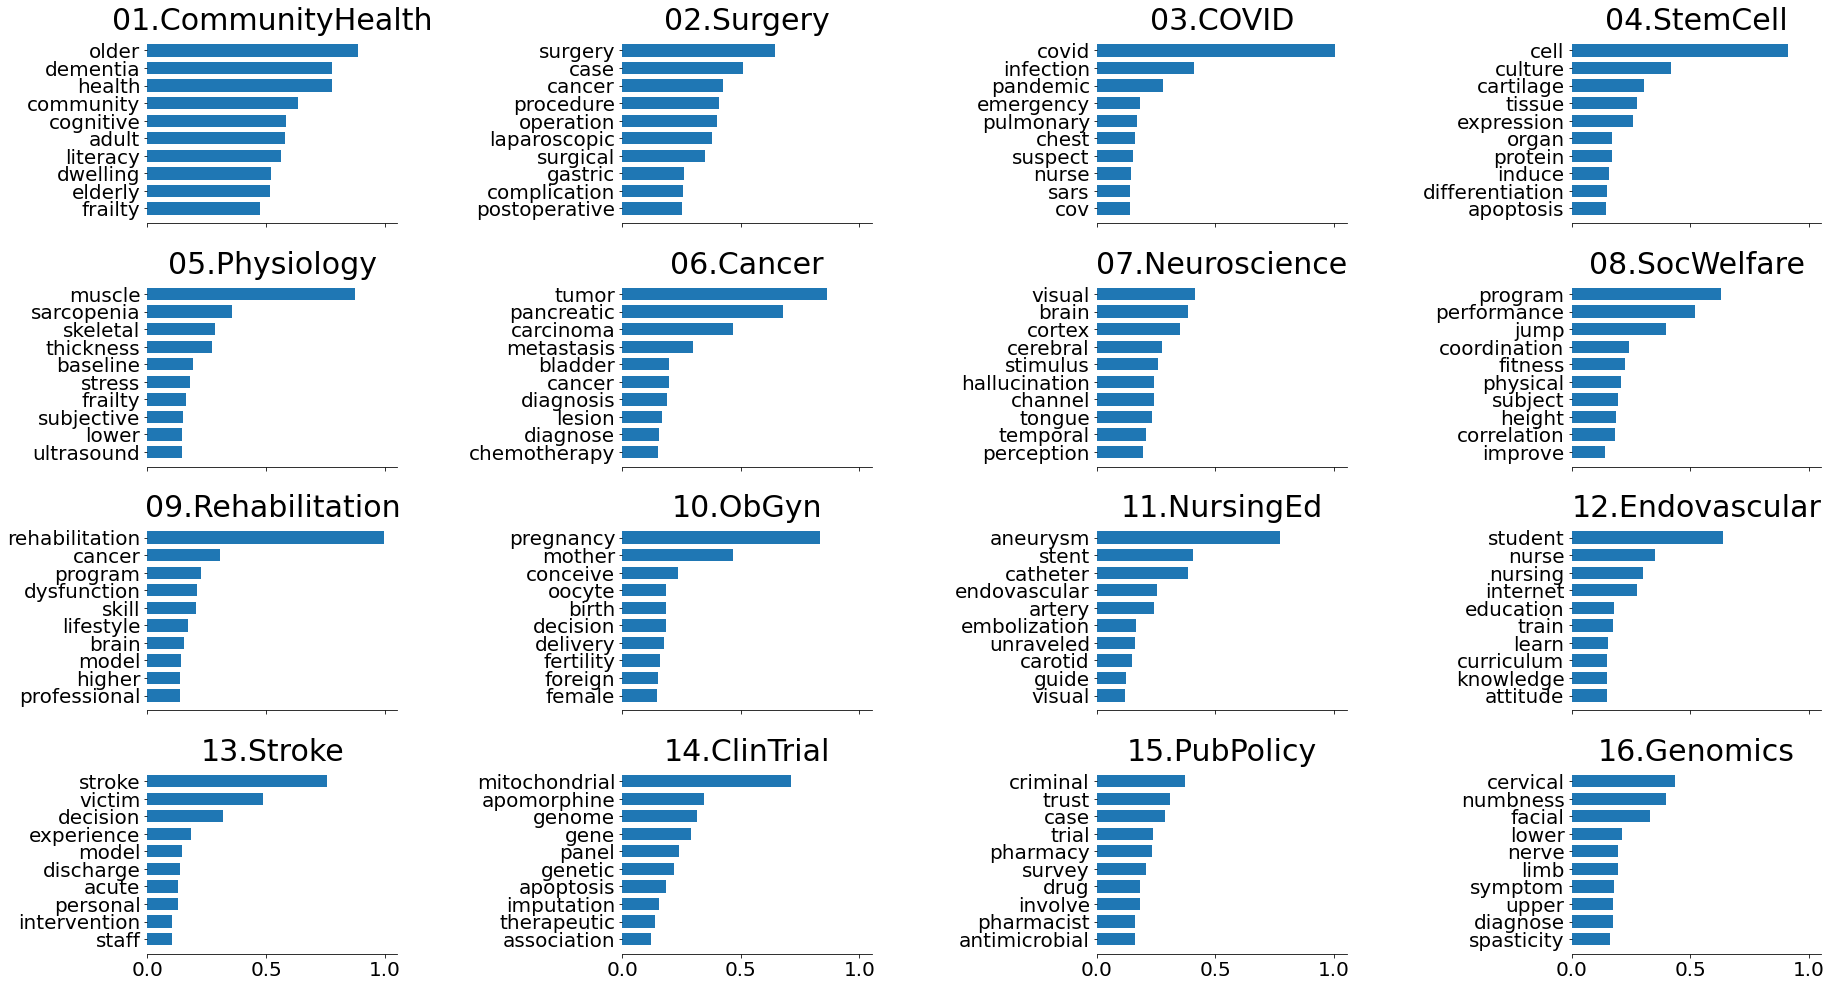

In [29]:
def plot_top_words(model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(4, 4, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):#[:10]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        #ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.set_title(tnames_human_16[topic_idx], fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        #fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    #plt.savefig('NMF08_topics.png')
    
plot_top_words(nmf_tfidf, tfidf_vectorizer.get_feature_names())